In [1]:
%load_ext autoreload
%autoreload 2

import gstools as gs
import intake
import os
import zarr
import pandas as pd
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client
from cmip6_downscaling import CLIMATE_NORMAL_PERIOD
from cmip6_downscaling.constants import KELVIN, PERCENT, SEC_PER_DAY
import rioxarray
from rasterio.enums import Resampling
from cmip6_downscaling.workflows.share import (
    chunks,
    future_time,
    get_cmip_runs,
    hist_time,
    xy_region,
)
from cmip6_downscaling.workflows.utils import get_store
import matplotlib.pyplot as plt
intake_esm.__version__

'2021.1.15'

In [2]:
import skdownscale

In [3]:
skdownscale.__file__

'/home/jovyan/scikit-downscale/skdownscale/__init__.py'

# access GCM data

In [4]:
from cmip6_downscaling.data.cmip import gcm_munge

In [5]:
activity_ids = ["CMIP", "ScenarioMIP"]
experiment_ids = ["historical", "ssp370"] #, "ssp126", "ssp245",  "ssp585"
member_ids = ["r1i1p1f1"]
source_ids = ["CanESM5"]#BCC-CSM2-MR"]
table_ids = ["day"]
grid_labels = ["gn"]
variables = 'tasmax'
variable_ids = [variables] #tasmax, tasmin, pr

In [6]:
col_url = "https://cmip6downscaling.blob.core.windows.net/cmip6/pangeo-cmip6.json"

col = intake.open_esm_datastore(col_url)
full_subset = col.search(
    activity_id=activity_ids,
    experiment_id=experiment_ids, 
    member_id=member_ids,
    table_id=table_ids,
    grid_label=grid_labels,
    variable_id=variable_ids,
    source_id=source_ids
)

In [7]:
gcm_ds_dict = full_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    storage_options={'account_name':'cmip6downscaling',
                     'account_key':os.environ.get('AccountKey', None)}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
keys = gcm_ds_dict.keys()
historical_gcm = gcm_munge(gcm_ds_dict[[k for k in keys if 'historical' in k][0]])
future_gcm = gcm_munge(gcm_ds_dict[[k for k in keys if 'ssp' in k][0]])

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
historical_gcm

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 60225)
Coordinates:
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1879, 64, 128), meta=np.ndarray>
Attributes:
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    YMDH_branch_time_in_parent:  5201:01:01:00
    activity_id:                 CMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        0.0
    branch_time_in_parent:       1223115.0
    cmor_version:                3.4.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-05-02T08:02:01Z
    data_specs_version:          01.00.29
    experiment:                  all-forcing simulation of the recent past
    experiment_id:               historical
    external_variables:          areacella
    forcing_index:               1
    frequency:                   day
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        T63L49 native atmosphere, T63 Linear Gaussia...
    grid_label:                  gn
    history:                     2019-05-02T08:02:01Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    netcdf_tracking_ids:         hdl:21.14100/7c67e43e-1378-466f-94fe-4aebc1e...
    nominal_resolution:          500 km
    parent_activity_id:          CMIP
    parent_experiment_id:        piControl
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p1f1
    physics_index:               1
    product:                     model-output
    realization_index:           1
    realm:                       atmos
    references:                  Geophysical Model Development Special issue ...
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    source_id:                   CanESM5
    source_type:                 AOGCM
    status:                      2020-07-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    day
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/7c67e43e-1378-466f-94fe-4aebc1e...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.day.gn

In [10]:
future_gcm

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 31390)
Coordinates:
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1883, 64, 128), meta=np.ndarray>
Attributes:
    CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
    CCCma_parent_runid:          rc3.1-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s7001
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    YMDH_branch_time_in_parent:  2015:01:01:00
    activity_id:                 ScenarioMIP AerChemMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        60225.0
    branch_time_in_parent:       60225.0
    cmor_version:                3.4.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-05-02T08:46:38Z
    data_specs_version:          01.00.29
    experiment:                  gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:               ssp370
    external_variables:          areacella
    forcing_index:               1
    frequency:                   day
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        T63L49 native atmosphere, T63 Linear Gaussia...
    grid_label:                  gn
    history:                     2019-05-02T08:46:38Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    netcdf_tracking_ids:         hdl:21.14100/7a8900a2-b1dd-4c19-9a27-2e6b35a...
    nominal_resolution:          500 km
    parent_activity_id:          CMIP
    parent_experiment_id:        historical
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p1f1
    physics_index:               1
    product:                     model-output
    realization_index:           1
    realm:                       atmos
    references:                  Geophysical Model Development Special issue ...
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    source_id:                   CanESM5
    source_type:                 AOGCM
    status:                      2020-07-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    day
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/7a8900a2-b1dd-4c19-9a27-2e6b35a...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5.ssp370.day.gn

# access obs data

In [11]:
# converts cmip standard names to ERA5 names
variable_name_dict = {
    'tasmax': 'air_temperature_at_2_metres_1hour_Maximum',
    'tasmin': 'air_temperature_at_2_metres_1hour_Minimum',
    'pr': 'precipitation_amount_1hour_Accumulation'
}

# specify spatial regional subset and time periods

In [12]:
from cmip6_downscaling.data.cmip import convert_to_360

# parameters
historical_start = '2010'
historical_end = '2014'
future_start = '2015'
future_end = '2019'
min_lat = 19
max_lat = 55
min_lon = 227
max_lon = 299

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [13]:
obs = xr.open_zarr('obs_buffer.zarr')
obs

,Array,Chunk
Bytes,772.72 MB,400.00 kB
Shape,"(3652, 169, 313)","(1000, 10, 10)"
Count,2177 Tasks,2176 Chunks
Type,float32,numpy.ndarray


In [14]:
historical_period = slice(historical_start, historical_end)
future_period = slice(future_start, future_end)

In [15]:
from cmip6_downscaling.data.observations import get_coarse_obs
def maca_preprocess(
    historical_gcm,
    future_gcm,
    obs,
    min_lon,
    max_lon,
    min_lat,
    max_lat,
):
    lon_slice = slice(convert_to_360(min_lon), convert_to_360(max_lon))
    lat_slice = slice(max_lat, min_lat)
    full_gcm = xr.combine_by_coords(
        [
            historical_gcm.sel(lon=lon_slice, lat=lat_slice),
            future_gcm.sel(lon=lon_slice, lat=lat_slice),
        ],
        combine_attrs='drop',
    ).rio.write_crs('EPSG:4326')
    obs = obs.chunk({'lat': -1, 'lon': -1, 'time': 1})
    coarse_obs = get_coarse_obs(obs=obs, gcm_ds_single_time_slice=full_gcm.isel(time=0))
    return full_gcm, coarse_obs

/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:220: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:252: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if num_peri_dims is not 0:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/grid.py:896: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(staggerloc) is 1:
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/util/slicing.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert (len(slc) is 3)
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if meshname is not "":
/srv/conda/envs/notebook/lib/python3.8/site-packages/ESMF/api/mesh.py:145: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if varname is not "":


In [16]:
full_gcm, coarse_obs = maca_preprocess(
    historical_gcm=historical_gcm.sel(time=historical_period),
    future_gcm=future_gcm.sel(time=future_period),
    obs=obs, 
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(


using dimensions ('lat', 'lon') from data variable tasmax as the horizontal dimensions for this dataset.


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:473: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


## bias correction 

In [ ]:
# bias correct future gcm and historical gcm to observation according to bias correction method specified 
# transform coarse obs if specified by bias correction method 

# fit & predict with Pointwise GARD model 
# fit --> X = coarse obs, y = fine obs 
# predict --> X = coarse historical or future gcm 

# do error calculations and perturb the answers as needed 


# Run GARD model

In [38]:
from skdownscale.pointwise_models import PureAnalog
from skdownscale.pipelines.gard_wrapper import GardWrapper

gard_model = PureAnalog(kind='mean_analogs', n_analogs=10)
gard_wrapper = GardWrapper(model=gard_model, feature_list=['tasmax'], dim='time')

In [51]:
gcm_train.transpose('time', 'lat', 'lon').load()
obs.transpose('time', 'lat', 'lon').load()

<xarray.DataArray 'tasmax' (time: 1095, lat: 21, lon: 20)>
array([[[279.6875, 278.25  , 276.5625, ..., 273.    , 272.6875,
         271.375 ],
        [279.25  , 280.    , 278.6875, ..., 272.75  , 272.6875,
         271.4375],
        [279.0625, 279.875 , 279.5625, ..., 272.125 , 272.0625,
         272.375 ],
        ...,
        [284.375 , 284.5625, 284.5   , ..., 277.0625, 279.125 ,
         281.125 ],
        [284.375 , 284.5   , 284.4375, ..., 276.875 , 276.875 ,
         278.5625],
        [284.5   , 284.625 , 284.25  , ..., 277.125 , 277.1875,
         277.125 ]],

       [[279.625 , 278.125 , 276.4375, ..., 272.25  , 271.875 ,
         270.875 ],
        [279.0625, 279.9375, 278.6875, ..., 272.    , 271.75  ,
         270.8125],
        [278.875 , 279.875 , 279.6875, ..., 272.125 , 271.875 ,
         271.6875],
...
        [281.3125, 281.3125, 281.4375, ..., 273.375 , 273.5625,
         273.5625],
        [281.5625, 281.625 , 281.6875, ..., 272.1875, 272.25  ,
         272.1875],
        [281.75  , 282.    , 281.5   , ..., 272.    , 272.0625,
         271.3125]],

       [[275.    , 273.3125, 271.9375, ..., 263.125 , 263.375 ,
         265.0625],
        [275.125 , 276.0625, 275.5   , ..., 264.    , 264.875 ,
         266.5625],
        [275.375 , 276.3125, 276.4375, ..., 264.875 , 265.75  ,
         267.0625],
        ...,
        [280.9375, 280.9375, 281.1875, ..., 273.1875, 273.25  ,
         273.0625],
        [281.    , 281.    , 281.1875, ..., 272.0625, 272.    ,
         271.75  ],
        [281.125 , 281.4375, 281.1875, ..., 272.    , 271.9375,
         271.5625]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-30
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float32 235.2 235.5 235.8 236.0 ... 239.2 239.5 239.8 240.0

In [57]:
model = gard_wrapper.fit(X=gcm_train, y=obs)

/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/

# Step 4: Predict for future (it's already on the coarse scale)

In [62]:
future = full_gcm[[variable]].sel(time=holdout_slice, lat=lat_slice, lon=lon_slice).load() #.rio.write_crs('EPSG:4326')
# future = conform_to_reproject(future).load()
future

<xarray.Dataset>
Dimensions:  (time: 730, lat: 2, lon: 2)
Coordinates:
  * lat      (lat) float64 48.84 46.04
  * lon      (lon) float64 236.2 239.1
  * time     (time) object 1990-01-01 12:00:00 ... 1991-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 272.2 268.4 278.7 ... 274.0 281.6 278.2
Attributes: (12/58)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.day.gn

In [64]:
future_downscaled = model.predict(future)

In [65]:
future_downscaled

<xarray.DataArray (time: 730, lat: 21, lon: 20)>
array([[[278.28125, 277.28125, 275.46875, ..., 272.76874, 272.575  ,
         271.675  ],
        [278.35626, 279.33124, 278.275  , ..., 272.18124, 270.3625 ,
         270.4    ],
        [278.7625 , 279.60626, 279.3375 , ..., 272.375  , 271.35626,
         270.16876],
        ...,
        [283.43124, 282.94376, 282.66876, ..., 277.5    , 278.18124,
         278.91876],
        [282.8625 , 283.55624, 281.64374, ..., 278.225  , 276.925  ,
         276.75626],
        [283.43124, 283.7    , 281.65625, ..., 277.45   , 277.     ,
         277.2    ]],

       [[275.61874, 274.46875, 273.5125 , ..., 271.85   , 271.425  ,
         271.4    ],
        [276.275  , 276.66876, 275.15625, ..., 271.33124, 270.9125 ,
         270.7375 ],
        [275.725  , 277.08124, 276.8875 , ..., 271.43124, 270.99374,
         270.5125 ],
...
        [283.70624, 283.61874, 284.5875 , ..., 282.40625, 281.54376,
         281.63126],
        [283.21875, 283.775  , 283.55624, ..., 279.1875 , 281.05   ,
         281.98126],
        [282.85   , 282.98126, 283.01874, ..., 280.2375 , 278.6875 ,
         278.59375]],

       [[282.3125 , 277.83124, 277.53125, ..., 268.275  , 270.91876,
         270.6125 ],
        [280.13126, 281.2875 , 277.61874, ..., 269.3875 , 269.38126,
         270.225  ],
        [280.725  , 279.16876, 280.11874, ..., 270.4625 , 271.28125,
         271.875  ],
        ...,
        [283.625  , 283.6375 , 283.1875 , ..., 282.68124, 284.38126,
         281.1875 ],
        [284.5125 , 284.04376, 283.98126, ..., 283.5375 , 283.3625 ,
         281.2875 ],
        [284.08124, 284.36874, 283.35   , ..., 279.725  , 280.44376,
         279.7    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48.84 48.84 48.84 48.84 ... 46.04 46.04 46.04 46.04
  * lon      (lon) float64 236.2 236.2 236.2 236.2 ... 239.1 239.1 239.1 239.1
  * time     (time) object 1990-01-01 12:00:00 ... 1991-12-31 12:00:00

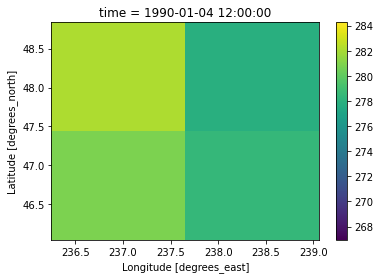

In [68]:
future_downscaled.isel(time=3).plot()   # this downscaling didn't work very well XD 